In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from JSPCA import jspca

test = pd.read_csv('./archive/mnist_test.csv')
test.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
y = test.label
x = test.drop('label', axis=1)
x.shape, y.shape

((10000, 784), (10000,))

In [3]:
A = np.vstack([x.loc[np.where(y == n)[0][:10], :] for n in range(10)]).T
A.shape

(784, 100)

In [4]:
P, Q_jspca = jspca(A, lambda_=0.05, maxiter=50, d=100)
Q_jspca.shape

(784, 100)

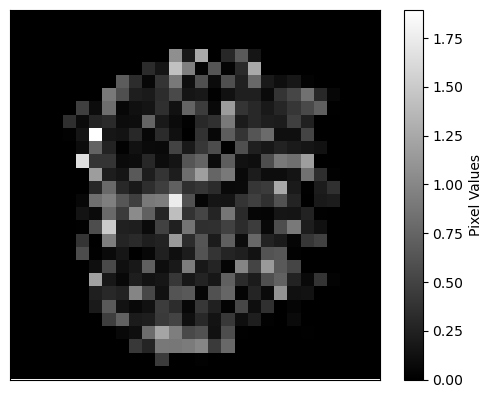

In [5]:
plt.imshow(np.abs(Q_jspca.sum(axis=1)).reshape(28,28), cmap='gray')
plt.colorbar(label='Pixel Values')
plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
class MyPCA:

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        # Standardize data
        X = X.copy()
        self.mean = np.mean(X, axis = 0)
        self.scale = np.std(X, axis = 0)
        if 0 not in self.scale :
          X_std = (X - self.mean) / self.scale
        else:
          X_std = X - self.mean

        # Eigendecomposition of covariance matrix
        cov_mat = np.cov(X_std.T)
        eig_vals, eig_vecs = np.linalg.eig(cov_mat)

        # Adjusting the eigenvectors that are largest in absolute value to be positive
        max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
        signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
        eig_vecs = eig_vecs*signs[np.newaxis,:]
        eig_vecs = eig_vecs.T

        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        eig_vals_sorted = np.array([x[0] for x in eig_pairs])
        eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

        self.components = eig_vecs_sorted[:self.n_components,:]

        # Explained variance ratio
        self.explained_variance_ratio = [i/np.sum(eig_vals) for i in eig_vals_sorted[:self.n_components]]

        self.cum_explained_variance = np.cumsum(self.explained_variance_ratio)

        return self

    def transform(self, X):
        X = X.copy()
        X_std = (X - self.mean) / self.scale
        X_proj = X_std.dot(self.components.T)
        return X_proj
    
    @property
    def Q_T(self):
      return self.components.T

In [7]:
my_pca = MyPCA(n_components = 100).fit(A.T)
Q_pca = my_pca.Q_T
Q_pca.shape

(784, 100)

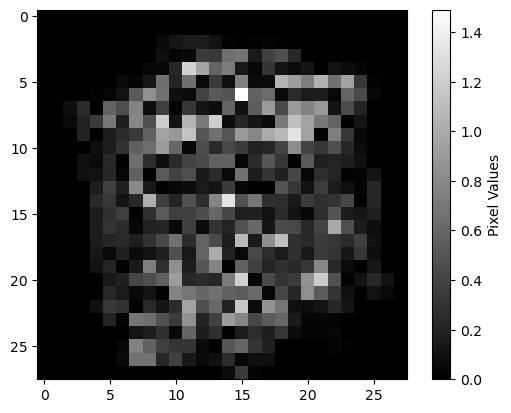

In [8]:
plt.imshow(np.abs(Q_pca.sum(axis=1)).reshape(28,28), cmap='gray')
plt.colorbar(label='Pixel Values')
plt.show()

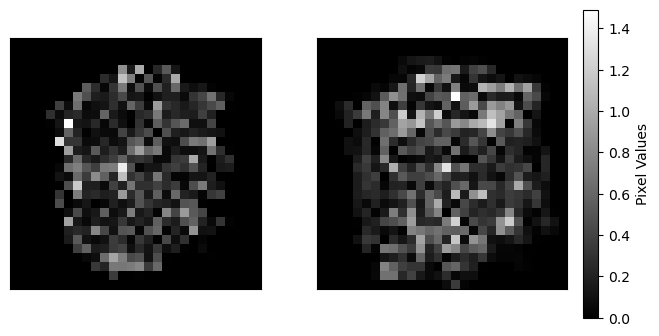

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1.25]})
axs[0].imshow(np.abs(Q_jspca.sum(axis=1)).reshape(28,28), cmap='gray')
I = axs[1].imshow(np.abs(Q_pca.sum(axis=1)).reshape(28,28), cmap='gray')
plt.colorbar(I, label='Pixel Values', ax=axs[1])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()

In [10]:
np.random.seed(42)
random_matrices = np.random.randint(0, 255, size=(784, 3))
black_img = np.zeros((784,1))
white_img = np.zeros((784,1)) + 255

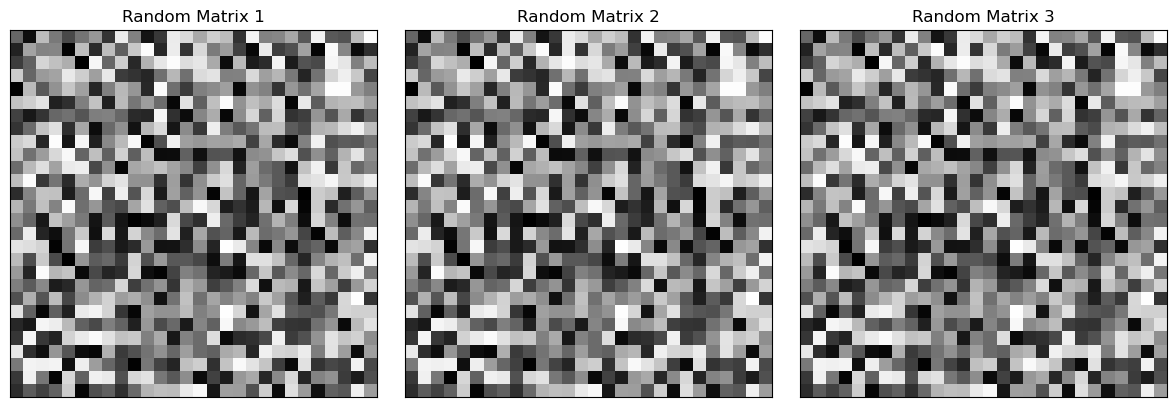

In [11]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(random_matrices[:,0].reshape(28,28), cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Random Matrix 1')
axs[1].imshow(random_matrices[:,0].reshape(28,28), cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Random Matrix 2')
axs[2].imshow(random_matrices[:,0].reshape(28,28), cmap='gray', vmin=0, vmax=255)
axs[2].set_title('Random Matrix 3')

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
# Adjust layout
plt.tight_layout()
plt.show()

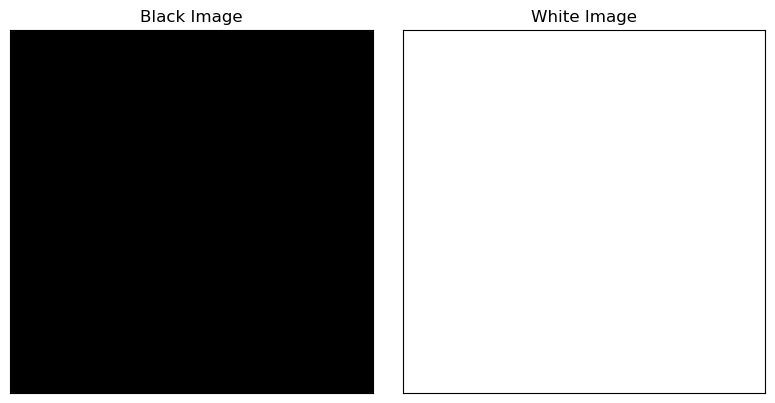

In [12]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot the second row
axs[0].imshow(black_img.reshape(28,28), cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Black Image')
axs[1].imshow(white_img.reshape(28,28), cmap='gray', vmin=0, vmax=255)
axs[1].set_title('White Image')

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
# Adjust layout
plt.tight_layout()
plt.show()

In [13]:
A_outlier = np.hstack([A, white_img, black_img, random_matrices])
A_outlier.shape

(784, 105)

In [14]:
P2, Q2_jspca = jspca(A_outlier, lambda_=0.05, maxiter=50, d=100)
Q2_jspca.shape

(784, 100)

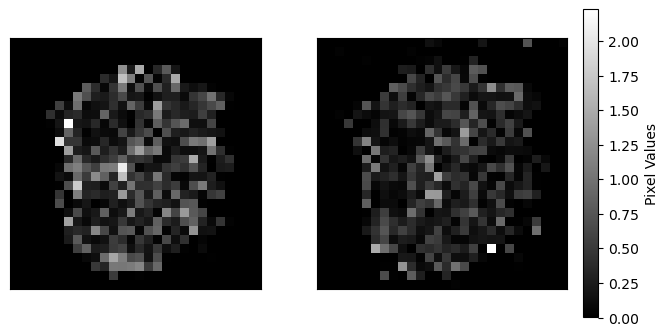

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1.25]})
axs[0].imshow(np.abs(Q_jspca.sum(axis=1)).reshape(28,28), cmap='gray')
I = axs[1].imshow(np.abs(Q2_jspca.sum(axis=1)).reshape(28,28), cmap='gray')
plt.colorbar(I, label='Pixel Values', ax=axs[1])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()

In [16]:
my_pca = MyPCA(n_components = 100).fit(A_outlier.T)
Q2_pca = my_pca.Q_T
Q2_pca.shape

(784, 100)

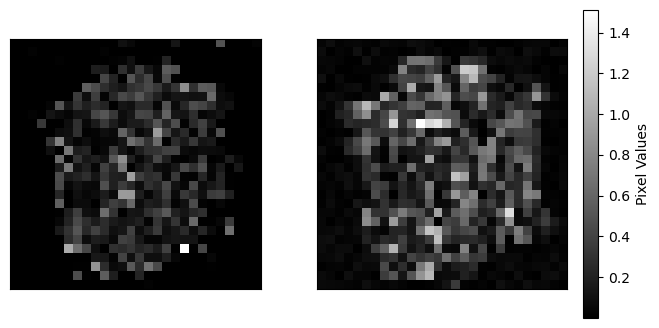

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1.25]})
axs[0].imshow(np.abs(Q2_jspca.sum(axis=1)).reshape(28,28), cmap='gray')
I = axs[1].imshow(np.abs(Q2_pca.sum(axis=1)).reshape(28,28), cmap='gray')
plt.colorbar(I, label='Pixel Values', ax=axs[1])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()